In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = sns.load_dataset('flights')
df.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [3]:
df['yearMonth'] = pd.to_datetime("01-"+df['month'].astype(str)+"-"+df['year'].astype(str))
df.set_index('yearMonth',inplace=True)
df

,year,month,passengers
yearMonth,,,
1949-01-01,1949,Jan,112
1949-02-01,1949,Feb,118
1949-03-01,1949,Mar,132
1949-04-01,1949,Apr,129
1949-05-01,1949,May,121
...,...,...,...
1960-08-01,1960,Aug,606
1960-09-01,1960,Sep,508
1960-10-01,1960,Oct,461


,year,month,passengers,rollMean,rollStd
yearMonth,,,,,
1960-01-01,1960,Jan,417,433.083333,66.624399
1960-02-01,1960,Feb,391,437.166667,61.866180
1960-03-01,1960,Mar,419,438.250000,61.382741
1960-04-01,1960,Apr,461,443.666667,60.171472
1960-05-01,1960,May,472,448.000000,60.184565
1960-06-01,1960,Jun,535,453.250000,65.021849
1960-07-01,1960,Jul,622,459.416667,77.194510
1960-08-01,1960,Aug,606,463.333333,83.630500
1960-09-01,1960,Sep,508,467.083333,84.617276


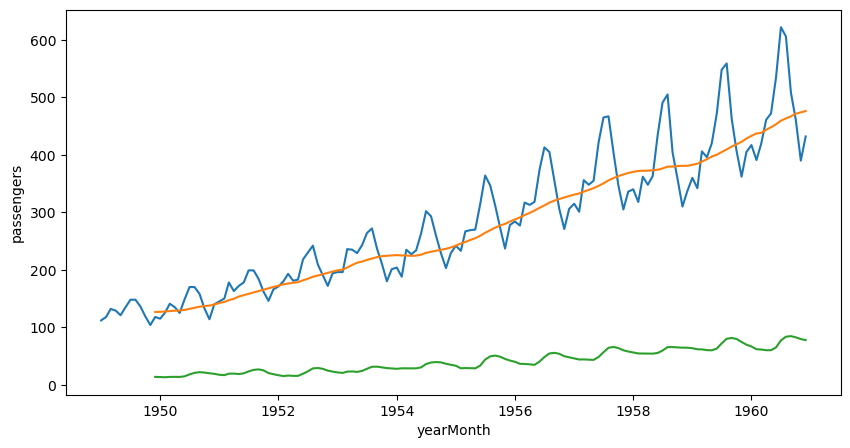

In [4]:
df['rollMean']  = df.passengers.rolling(window=12).mean() # ค่าเฉลี่ย 12 เดือนย้อนหลัง
df['rollStd']  = df.passengers.rolling(window=12).std() # std 12 เดือนย้อนหลัง
plt.figure(figsize=(10,5))
sns.lineplot(data=df,x=df.index,y=df.passengers)
sns.lineplot(data=df,x=df.index,y=df.rollMean)
sns.lineplot(data=df,x=df.index,y=df.rollStd)
df.tail(12)

In [5]:
# ค่าเฉลี่ยไม่คงที่ ต้องแปลงให้คงที่
# std คงที่ (ถ้าไม่คงที่ต้องใช้ ARCH)

In [6]:
from statsmodels.tsa.stattools import adfuller

adf_res = adfuller(df['passengers'], autolag = 'AIC')
print('p-Values:' + str(adf_res[1]))
# ถ้า p-Value มีค่าน้อยกว่า 0.05 จะสามารถสรุปได้ว่า Time series นั้นเป็น Stationary

p-Values:0.9918802434376411


In [7]:
stats = pd.Series(adf_res[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
stats

Test Statistic                   0.815369
p-value                          0.991880
#lags used                      13.000000
number of observations used    130.000000
dtype: float64

In [8]:
for key, values in adf_res[4].items():
    print('criticality',key,":",values)

criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


p-Values:0.038629757676988535


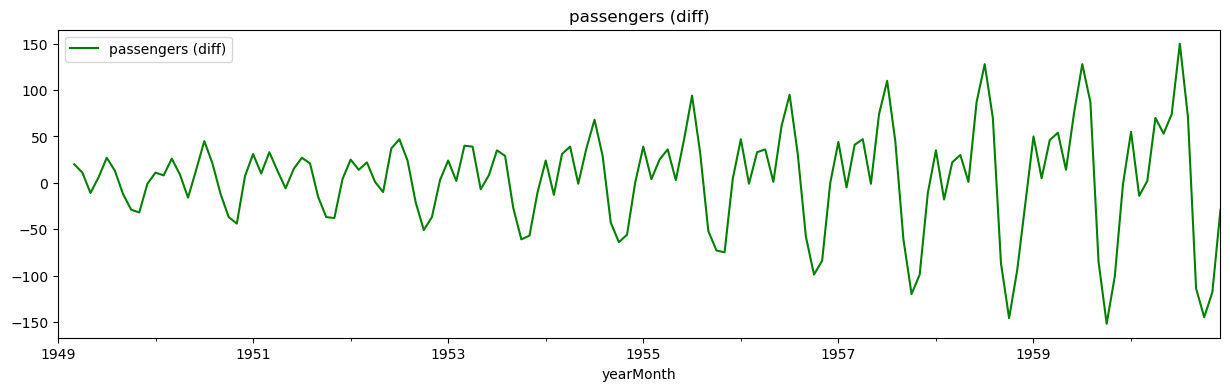

In [9]:
df['passengers_diff'] = df['passengers'].diff(2)
df['passengers_diff'].plot(color = 'green', figsize = (15,4))
plt.legend(['passengers (diff)'])
plt.title('passengers (diff)')

adf_res = adfuller(df['passengers_diff'].dropna(), autolag = 'AIC')
print('p-Values:' + str(adf_res[1]))
# หา d ที่ทำให้ stationary

In [10]:
df

,year,month,passengers,rollMean,rollStd,passengers_diff
yearMonth,,,,,,
1949-01-01,1949,Jan,112,NaN,NaN,NaN
1949-02-01,1949,Feb,118,NaN,NaN,NaN
1949-03-01,1949,Mar,132,NaN,NaN,20.0
1949-04-01,1949,Apr,129,NaN,NaN,11.0
1949-05-01,1949,May,121,NaN,NaN,-11.0
...,...,...,...,...,...,...
1960-08-01,1960,Aug,606,463.333333,83.630500,71.0
1960-09-01,1960,Sep,508,467.083333,84.617276,-114.0
1960-10-01,1960,Oct,461,471.583333,82.541954,-145.0


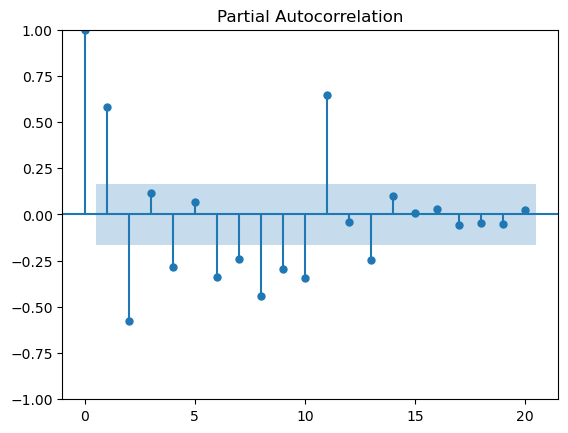

In [11]:
from statsmodels.graphics.tsaplots import  plot_pacf
plot_pacf(df.passengers_diff.dropna(),lags=20);
# ใช้เลือก AR(p)

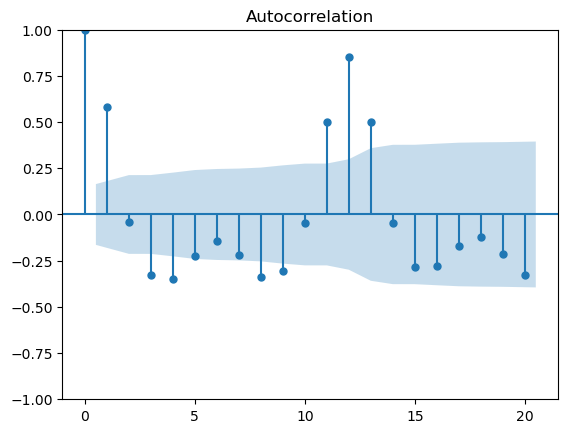

In [12]:
from statsmodels.graphics.tsaplots import  plot_acf
plot_acf(df.passengers_diff.dropna(),lags=20);
# หา MA(q)

In [13]:
train = df[:round(len(df)*70/100)]
test = df[round(len(df)*70/100):]
train.head()
# แยก train set and test set

,year,month,passengers,rollMean,rollStd,passengers_diff
yearMonth,,,,,,
1949-01-01,1949,Jan,112,NaN,NaN,NaN
1949-02-01,1949,Feb,118,NaN,NaN,NaN
1949-03-01,1949,Mar,132,NaN,NaN,20.0
1949-04-01,1949,Apr,129,NaN,NaN,11.0
1949-05-01,1949,May,121,NaN,NaN,-11.0


In [14]:
# หาพารามิเตอร์ที่ดีที่สุดสำหรับ model arima
import pmdarima
from pmdarima import auto_arima
# Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(train['passengers'], trace = True,
error_action ='ignore', # we don't want to know if an order does not work
suppress_warnings = True) # we don't want convergence warnings
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=917.952, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=915.557, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=913.419, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=917.028, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=908.790, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=913.567, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=907.742, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=912.115, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=914.276, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=905.043, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=912.604, Time=0.03 se

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  101
Model:               SARIMAX(4, 1, 2)   Log Likelihood                -444.016
Date:                Mon, 15 Jul 2024   AIC                            902.032
Time:                        14:48:09   BIC                            920.268
Sample:                    01-01-1949   HQIC                           909.413
                         - 05-01-1957                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1241      0.158      0.784      0.433      -0.186       0.434
ar.L2          0.3490      0.166      2.104      0.035       0.024       0.674
ar.L3         -0.1562      0.116     -1.344      0.179      -0.384       0.072
ar.L4         -0.2275      0.126     -1.813      0.070      -0.474       0.018
ma.L1          0.0827      0.150      0.551      0.582      -0.212       0.377
ma.L2         -0.6748      0.159     -4.247      0.000      -0.986      -0.363
sigma2       416.0043     70.755      5.880      0.000     277.327     554.682
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):                 5.92
Prob(Q):                              0.50   Prob(JB):                         0.05
Heteroskedasticity (H):               3.36   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# ถ้า L1 ปฏิเสธสมมติฐานหลัก แสดงว่าตัวแปรมีความสัมพันธ์กับตัวเอง (autocorrealation)
# ถ้า JB ปฏิเสธสมมติฐานหลัก แสดงว่า error term ไม่ได้มีการกระจายตัวปกติ

In [16]:
#(p, d, q)
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['passengers'], order = (4, 1, 3))
results = model.fit()
print(results.summary())

C:\Users\Tanyathep\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Tanyathep\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Tanyathep\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                  101
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -433.993
Date:                Mon, 15 Jul 2024   AIC                            883.985
Time:                        14:48:10   BIC                            904.827
Sample:                    01-01-1949   HQIC                           892.420
                         - 05-01-1957                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8264      0.129      6.427      0.000       0.574       1.078
ar.L2          0.4027      0.152      2.658      0.008       0.106       0.700
ar.L3         -0.6572      0.125     -5.264      0.0

C:\Users\Tanyathep\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='yearMonth', ylabel='passengers'>

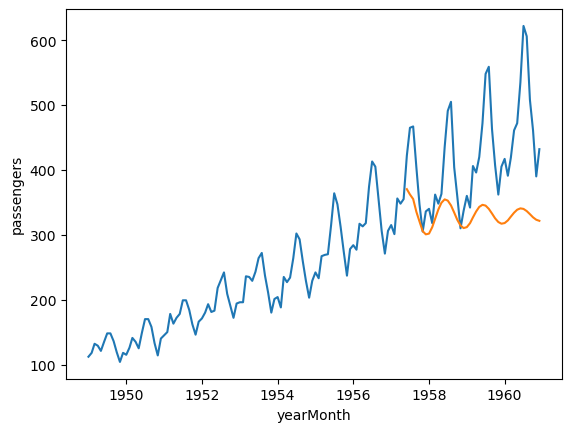

In [17]:
# เทียบข้อมูล train กับ test
prediction = results.predict(start=test.index[0], end=test.index[-1])
df['arimaPred'] = prediction
df.dropna()
sns.lineplot(data=df, x=df.index, y='passengers')
sns.lineplot(data=df, x=df.index, y='arimaPred')

In [18]:
import pmdarima
from pmdarima import auto_arima
# Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(train['passengers'], m = 12, seasonal = True, trace = True, # m คือจำนวนเวลาสำหรับ 1 รอบ 
error_action ='ignore', # we don't want to know if an order does not work
suppress_warnings = True) # we don't want convergence warnings
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=654.029, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=657.288, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=650.553, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=651.123, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=652.376, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=652.523, Time=0.16 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=652.538, Time=0.14 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=650.954, Time=0.10 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.13 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=653.919, Time=0.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=652.418, Time=0.12 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=651.963, Time=0.17 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=650.738, Time=0.08 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=653.897, Time=0.20 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  101
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -322.277
Date:                            Mon, 15 Jul 2024   AIC                            650.553
Time:                                    14:48:13   BIC                            657.985
Sample:                                01-01-1949   HQIC                           653.548
                                     - 05-01-1957                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2445      0.096     -2.551      0.011      -0.432      -0.057
ar.S.L12      -0.2124      0.086     -2.456      0.014      -0.382      -0.043
sigma2        88.1997     13.733      6.422      0.000      61.284     115.116
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.40
Prob(Q):                              0.96   Prob(JB):                         0.30
Heteroskedasticity (H):               1.30   Skew:                             0.40
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['passengers'], order = (1, 1, 0), seasonal_order=(1,1,0,12))
results = model.fit()
print(results.summary())

                                    SARIMAX Results                                     
Dep. Variable:                       passengers   No. Observations:                  101
Model:             ARIMA(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -322.277
Date:                          Mon, 15 Jul 2024   AIC                            650.553
Time:                                  14:48:13   BIC                            657.985
Sample:                              01-01-1949   HQIC                           653.548
                                   - 05-01-1957                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2445      0.096     -2.551      0.011      -0.432      -0.057
ar.S.L12      -0.2124      0.086     -2.456      0.

C:\Users\Tanyathep\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Tanyathep\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Tanyathep\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='yearMonth', ylabel='passengers'>

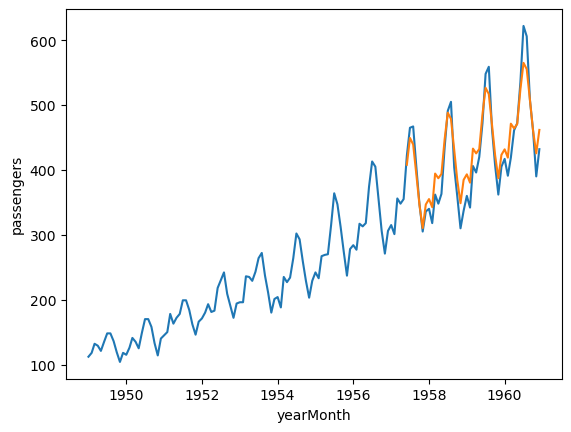

In [20]:
prediction = results.predict(start=test.index[0], end=test.index[-1])
df['arimaPred'] = prediction
df.dropna()
sns.lineplot(data=df, x=df.index, y='passengers')
sns.lineplot(data=df, x=df.index, y='arimaPred')

In [21]:
# ลองทำนาย
futureDate = pd.DataFrame(pd.date_range(start='1961-01-01', end='1962-12-01',freq='MS'),columns=['Dates'])
futureDate.set_index('Dates',inplace=True)
results.predict(start=futureDate.index[0],end=futureDate.index[-1])

1961-01-01    470.165450
1961-02-01    457.389141
1961-03-01    509.766933
1961-04-01    502.466188
1961-05-01    509.116560
1961-06-01    562.613940
1961-07-01    603.506968
1961-08-01    593.895385
1961-09-01    546.532478
1961-10-01    499.458129
1961-11-01    464.108140
1961-12-01    500.159493
1962-01-01    508.633785
1962-02-01    495.860500
1962-03-01    548.231811
1962-04-01    540.932795
1962-05-01    547.582303
1962-06-01    601.080992
1962-07-01    641.973030
1962-08-01    632.362290
1962-09-01    584.998003
1962-10-01    537.922646
1962-11-01    502.572840
1962-12-01    538.623642
Freq: MS, Name: predicted_mean, dtype: float64

<Axes: xlabel='yearMonth', ylabel='passengers'>

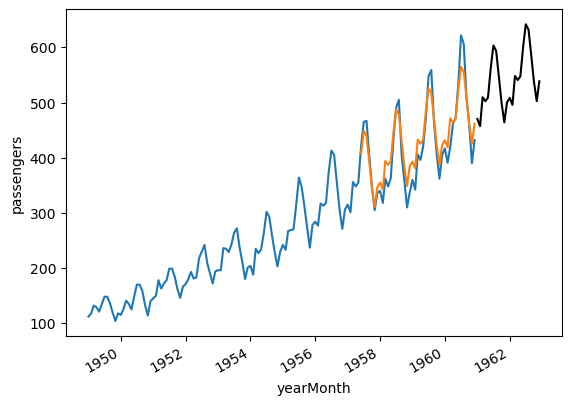

In [22]:
df.dropna()
sns.lineplot(data=df, x=df.index, y='passengers')
sns.lineplot(data=df, x=df.index, y='arimaPred')
results.predict(start=futureDate.index[0],end=futureDate.index[-1]).plot(color='black')

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
print(mean_squared_error(test['Revenue'],prediction))
print(mean_absolute_percentage_error(test['Revenue'],prediction))
# วัด error

KeyError: 'Revenue'

In [ ]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = auto_arima(train[['passengers']], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

In [ ]:
prediction = SARIMAX_model.predict(n_periods=len(test))
df['arimaPred'] = prediction
df.dropna()
sns.lineplot(data=df, x=df.index, y='passengers')
sns.lineplot(data=df, x=df.index, y='arimaPred')